In [8]:
from script.condition import activity, boundary_condition

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import os
import joblib

from matplotlib import cm
from matplotlib.tri import Triangulation
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_dict = joblib.load('./data/scaler_dict.pkl') # 0: formate, 1: CO, 2: CORR, 3: HER

# Selectivity HeatMap

## Calculate Selectivity

In [10]:
products = ['formate','co','c1','h2'] # expected CO2RR products
data_path = 'data/energy/'
csv_lst =  os.listdir(data_path) # collect DataFrame with predicted energy of alloy

eU = -1.4 # applied potential
dens_dict = {}

for csv in tqdm.tqdm(csv_lst):
    df = pd.read_csv(data_path + csv, index_col=0)
    df.drop_duplicates(['FNN','Same','Sub'], inplace = True)
    
    name_f = csv.split('.')[0]             # A_B
    active_A, active_B = name_f.split('_')
    name_r = '_'.join([active_B,active_A]) # B_A
    
    fnn_lst = [literal_eval(i) for i in df['FNN']] # binding site
    co_lst = df['co'].to_numpy()
    oh_lst = df['oh'].to_numpy()
    h_lst  = df['h'].to_numpy()
    
    for active, name in zip([active_A,active_B],[name_f,name_r]): # Seperate active motif by active site metal
        total = 0
        density = np.zeros(4)
        
        for fnn,x,y,z in zip(fnn_lst, co_lst, h_lst, oh_lst):
            if list(fnn.keys())[0] == active: # consider only when metal A or B included in FNN
                total += 1
                product = boundary_condition(x,y,z,eU) 
                barrier = activity(x,y,z,eU,product)
                
                if barrier <= 0:
                    density[products.index(product)] += 1 
        
        density /= total
        
        for idx,dens in enumerate(density): # Normalizng
            density[idx] = scaler_dict[eU][idx].transform(np.array([dens]).reshape(-1,1))[0][0]
            
        dens_dict[name] = density

100%|██████████| 465/465 [00:55<00:00,  8.35it/s]


## Visualize Heatmap

In [11]:
# assigning selectivity to metal coordinates of Heatmap

metal_lst = ['Ag', 'Al', 'As', 'Au', 'Co', 'Cr', 'Cu', 'Fe', 'Ga', 'Ge', 'In', 
             'Ir', 'Mn', 'Mo', 'Ni', 'Os', 'Pb', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 
             'Sb', 'Se', 'Si', 'Sn', 'Ti', 'V', 'W', 'Zn']

density_by_alloy = dict()

for base in metal_lst:
    density_by_alloy[base] = dict()
    for func in metal_lst:
        try:
            density_by_alloy[base][func] = dens_dict['_'.join([base,func])]
        except KeyError:
            density_by_alloy[base][func] = dens_dict['_'.join([func,base])]

values = []
for i in range(4):
    val = []
    
    if i in [0]:
        for row in reversed(metal_lst):
            for col in metal_lst:
                val.append(density_by_alloy[col][row][0])
        values.append(val)
    elif i in [1]:
        for row in reversed(metal_lst):
            for col in metal_lst:
                val.append(density_by_alloy[col][row][1])
        values.append(val)
    elif i in [2]:
        for row in reversed(metal_lst):
            for col in metal_lst:
                val.append(density_by_alloy[col][row][2])
        values.append(val)
    elif i in [3]:
        for row in reversed(metal_lst):
            for col in metal_lst:
                val.append(density_by_alloy[col][row][3])
        values.append(val)

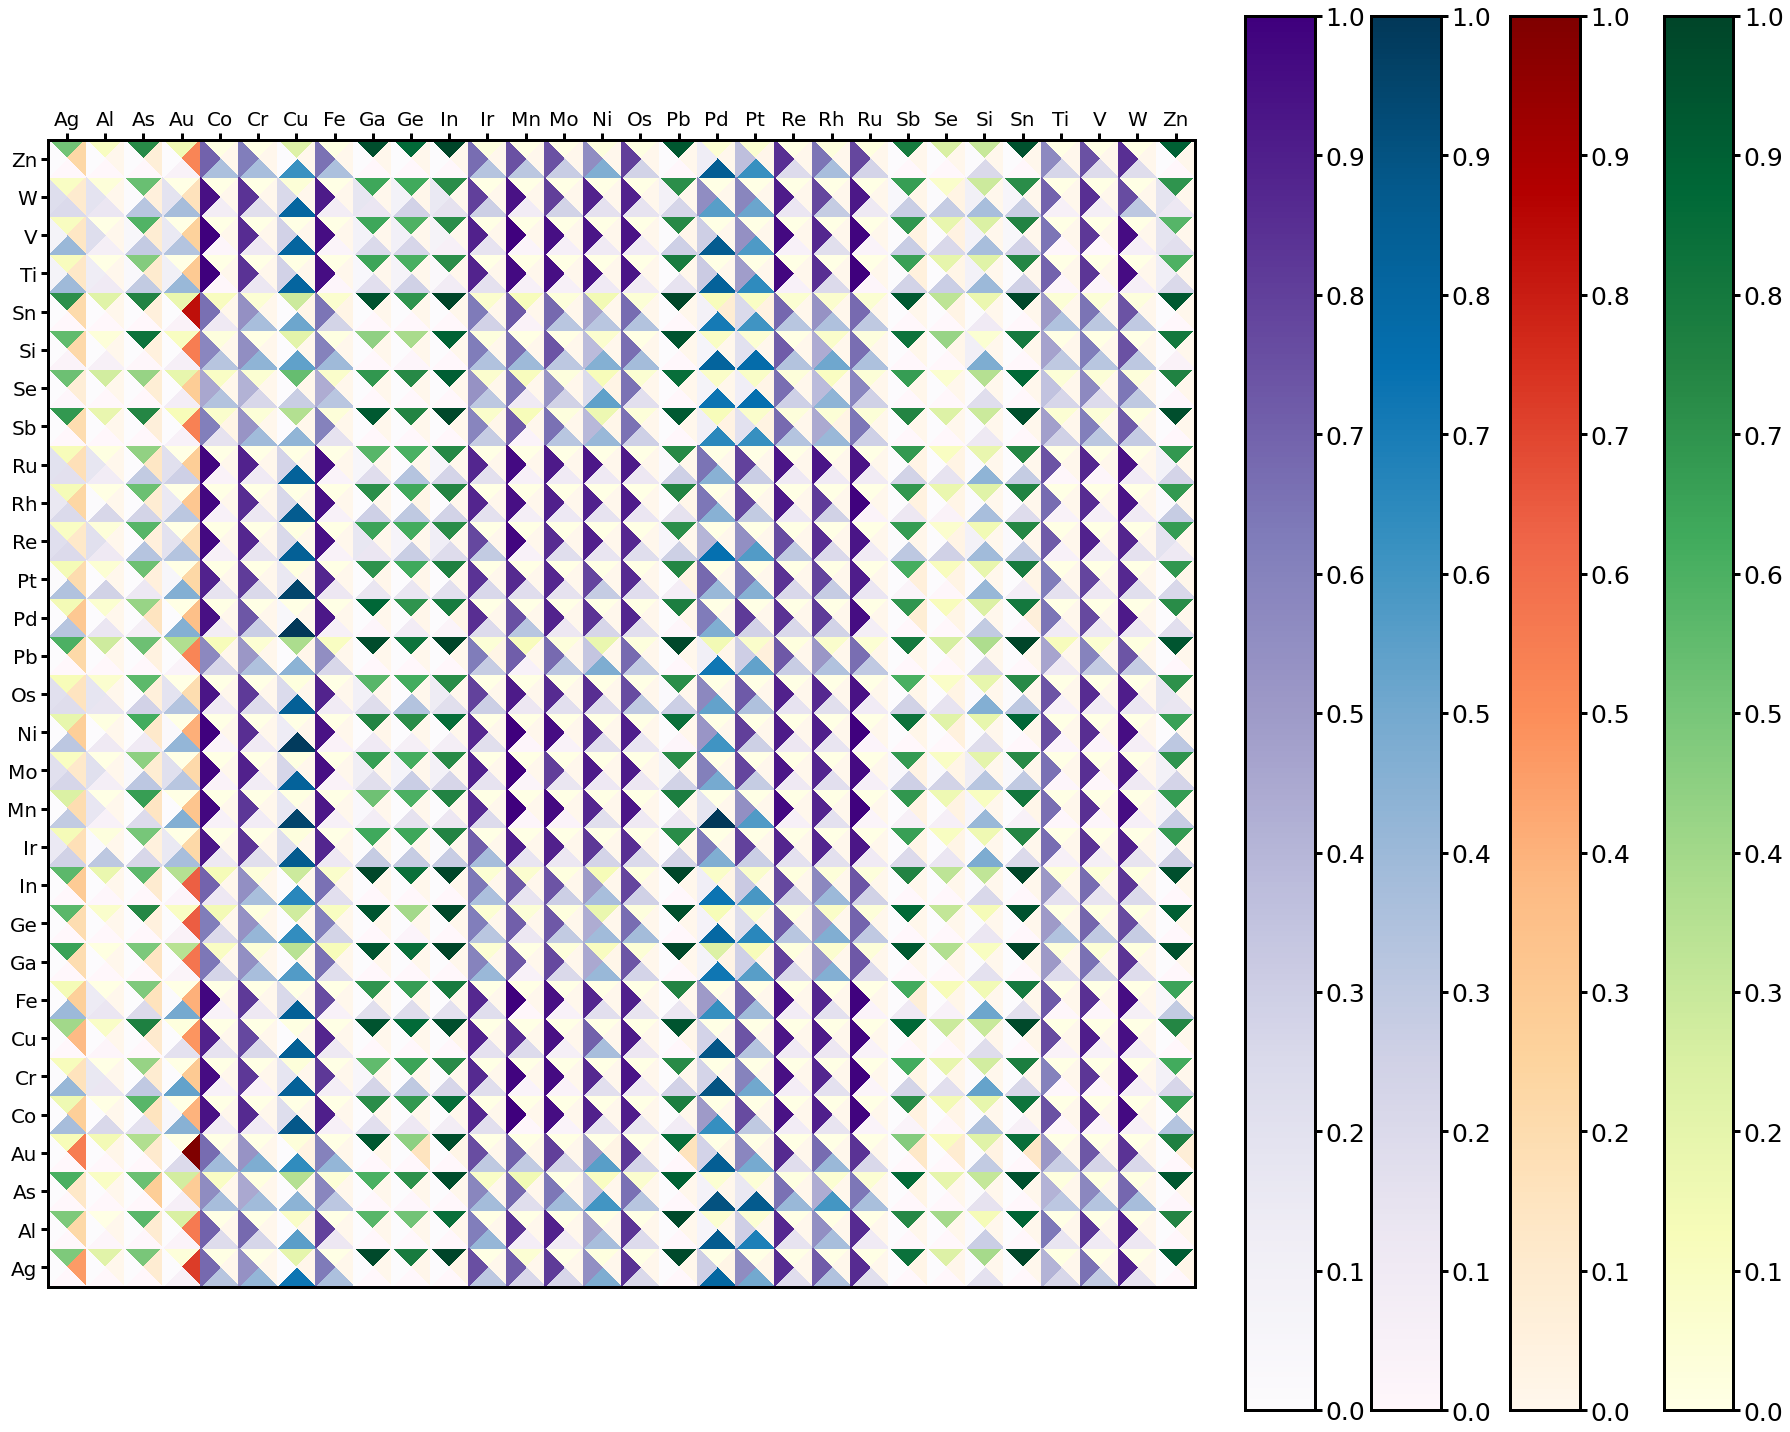

In [13]:
# draw Heatmap

N = 30
M = 30

xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares

x = np.concatenate([xv.ravel(), xc.ravel()])
y = np.concatenate([yv.ravel(), yc.ravel()])

cstart = (M+1) * (N+1)

# set vertex and center coordinates
triangles1 = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
              for j in range(N) for i in range(M)]
triangles2 = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
              for j in range(N) for i in range(M)]
triangles3 = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
              for j in range(N) for i in range(M)]
triangles4 = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
              for j in range(N) for i in range(M)]

triangul = [Triangulation(x, y, triangles) for triangles in [triangles1, triangles2, triangles3, triangles4]]

c1 = 'YlGn'    # Formate
c2 = 'OrRd'    # CO
c3 = 'PuBu'    # C1
c4 = 'Purples' # H2

cmaps = [c1,c2,c3,c4] 
norms = [plt.Normalize(0, 1), plt.Normalize(0, 1), plt.Normalize(0, 1), plt.Normalize(0, 1)]

fig, ax = plt.subplots(1,1,figsize=[25,20])

imgs = [ax.tripcolor(t, val, cmap=cmap, norm=norm, ec='white', lw=0)
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]

# Heatmap
ax.set_xticks(range(M))
ax.set_xticklabels(metal_lst,fontsize=20)
ax.set_yticks(range(N))
ax.set_yticklabels(reversed(metal_lst),fontsize=20)
ax.set_ylim([-0.5,29.5])
ax.invert_yaxis()
ax.margins(x=0, y=0)
ax.set_aspect('equal', 'box')  # square cells
[ax.spines[i].set_linewidth(3) for i in ax.spines.keys()]
ax.tick_params(width=3, size=7)

# Colorbar
cbar = [plt.colorbar(imgs[i],fraction=0.055,pad=0.04) for i in [0,1,2,3]]
[cb.ax.tick_params(width=3, size=7, labelsize=25) for cb in cbar]
[[cb.ax.spines[i].set_linewidth(3) for i in cb.ax.spines.keys()] for cb in cbar]
[cb.ax.set_yticks([1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0]) for cb in cbar]
plt.tight_layout()
ax.xaxis.tick_top()

plt.savefig('./figure/Heatmap.svg')